In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob

import os

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [4]:
IMGS_ATTR_PATH = './archive/list_attr_celeba.csv'
IMGS_PATH = './archive/images'

FACE_WEIGHT_VGG16 = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'

MODEL_20_EPOCHS = 'https://drive.google.com/uc?id=18N6-jvBPCODlgyyo0YiPiPTUxeyGBk0q'
MODEL_NAME = 'model_20_epoch.h5'

In [3]:
gdown.download(MODEL_20_EPOCHS, MODEL_NAME)

Downloading...
From: https://drive.google.com/uc?id=18N6-jvBPCODlgyyo0YiPiPTUxeyGBk0q
To: C:\Users\mtvuu\Documents\Projects\computer vision\attractiveness\model_20_epoch.h5
100%|█████████████████████████████████████████████████████████████████████████████| 95.7M/95.7M [00:03<00:00, 25.3MB/s]


'model_20_epoch.h5'

In [5]:
def get_attr_names(dataframe):
    '''
    This function returns attr names using in dataset.
    
    Params:
        dataframe (pd.Dataframe)
        
    Return:
        attr_names (list): A list object containing the name of attribute name of celeb faces.
    '''
    attr_names = []
    attr_names = list(dataframe.columns)
    # removing images_id column
    del attr_names[0]
    
    return attr_names

def attr_to_onehot(array):
    '''
    This function just make attr values in array to onehot by changing -1 to 0.
    '''
    result = np.copy(array)
    result[result == -1] = 0
    return result

def split_dataset(ds, percentage=0.2):
    '''
    This function can split the dataset in two parts with given percentage.
    
    Params: 
        ds (np.array): Numpy array representing dataset.
        percentage (float, optional): Between 0 and 1.
        
    Returns:
        main (np.array): This array contains lenght of 1-percentage of total dataset.
        other (np.array): This array contains length of percentage of total dataset.
    '''
    cut_size = int(percentage * len(ds))
    cut_indices = np.random.randint(0, len(ds), size=(cut_size, ))
    
    other = ds[cut_indices]
    main = np.delete(ds, cut_indices, axis=0)
    
    print('--------------------------------------')
    print("TOTAL:\t{} \nFIRST:\t{} \nSECOND:\t{}".format(len(ds), len(main), len(other)))
    print('--------------------------------------')
    
    return main, other

def plot_attr(attr_names):
    f = plt.figure(figsize=(20, 15))
    for i, attr_name in enumerate(attr_names):
        f.add_subplot(4, 10, i+1)
        col = attr_df[attr_name]
        g = sns.barplot(x=col.value_counts().index, y=col.value_counts(normalize=True))
        g.set(ylim=(0, 1))
        plt.yticks([])
    plt.show()

In [6]:
attr_df = pd.read_csv(IMGS_ATTR_PATH)
attr_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


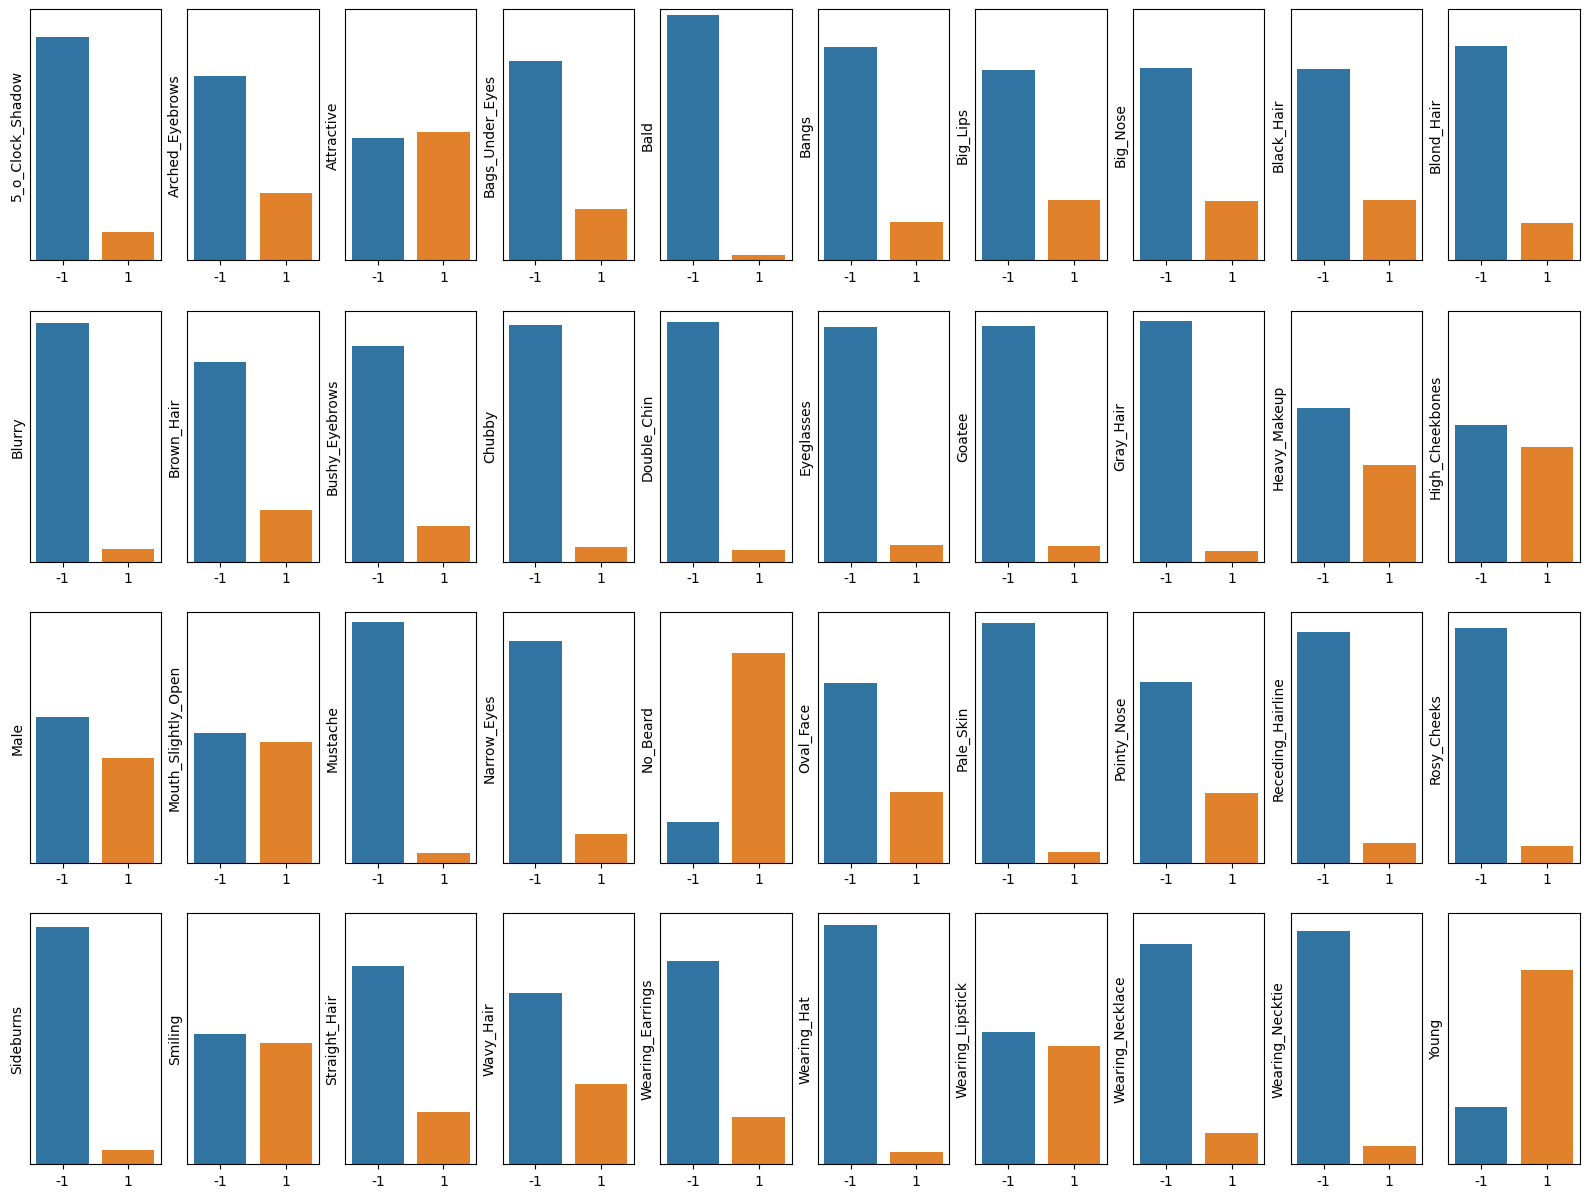

In [7]:
attr_names = get_attr_names(attr_df)
plot_attr(attr_names)

In [9]:
attr2idx = {v:i for i, v in enumerate(attr_names)}
attr2idx

{'5_o_Clock_Shadow': 0,
 'Arched_Eyebrows': 1,
 'Attractive': 2,
 'Bags_Under_Eyes': 3,
 'Bald': 4,
 'Bangs': 5,
 'Big_Lips': 6,
 'Big_Nose': 7,
 'Black_Hair': 8,
 'Blond_Hair': 9,
 'Blurry': 10,
 'Brown_Hair': 11,
 'Bushy_Eyebrows': 12,
 'Chubby': 13,
 'Double_Chin': 14,
 'Eyeglasses': 15,
 'Goatee': 16,
 'Gray_Hair': 17,
 'Heavy_Makeup': 18,
 'High_Cheekbones': 19,
 'Male': 20,
 'Mouth_Slightly_Open': 21,
 'Mustache': 22,
 'Narrow_Eyes': 23,
 'No_Beard': 24,
 'Oval_Face': 25,
 'Pale_Skin': 26,
 'Pointy_Nose': 27,
 'Receding_Hairline': 28,
 'Rosy_Cheeks': 29,
 'Sideburns': 30,
 'Smiling': 31,
 'Straight_Hair': 32,
 'Wavy_Hair': 33,
 'Wearing_Earrings': 34,
 'Wearing_Hat': 35,
 'Wearing_Lipstick': 36,
 'Wearing_Necklace': 37,
 'Wearing_Necktie': 38,
 'Young': 39}

In [8]:
attr_np = np.array(attr_df)
attr_np.shape

(202599, 41)

In [9]:
celeb_dataset = attr_to_onehot(attr_np)
celeb_dataset[:5]

array([['000001.jpg', 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1],
       ['000002.jpg', 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1],
       ['000003.jpg', 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1],
       ['000004.jpg', 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1],
       ['000005.jpg', 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1]], dtype=object)

In [10]:
train_np, test_np = split_dataset(celeb_dataset, 0.1)

--------------------------------------
TOTAL:	202599 
FIRST:	183335 
SECOND:	20259
--------------------------------------


In [11]:
def load_to_tfds(array):
    """
    This function just take np.array and extract imgs_path and attr_list
    seperately and then make seperate tensorflow dataset for both. Return 
    tensorflow dataset by zipping these two generated datasets.

    Args:
        array (np.array): Numpy array representing dataset

    Returns:
        ds (tf.data.Dataset): Tensorflow dataset containing zipped image and 
                              Respective attributes list.
    """ 
    img_path = array[:, 0]
    img_attrs = array[:, 1:]
    path_ds = tf.data.Dataset.from_tensor_slices(img_path)
    attrs_ds = tf.data.Dataset.from_tensor_slices(img_attrs.astype(np.int16))
    
    ds = tf.data.Dataset.zip((path_ds, attrs_ds))
    
    return ds

def load_and_process_image(name, attrs, augment=False):
    """
    This function take name(of image) and attrs(of image) and returns
    loaded image with attrs.

    Args:
        name (tf.string): String representing the name of image.
        attrs (tf.int): List representing the attributes of image.

    Returns:
        (image, attrs): Loaded image with attributes list.
    """
    full_path = IMGS_PATH + os.sep + name
    print(full_path)
    image = tf.io.read_file(full_path)
    image = tf.io.decode_jpeg(contents=image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255.)
    image = tf.image.resize(image, size=(112, 112))
    if (augment):
        image = tf.image.random_flip_left_right(image)
    
    return image, attrs

def preprocess_ds(ds, batch_size=128):
    """
    Batch and prefetch batched thats it.

    Args:
        ds (tf.data.Dataset): Tensorflow dataset
        batch_size (int, optional): Number of items to be in single batch. Defaults to 128.

    Returns:
        ds: Tensorflow dataset
    """
    ds = ds.shuffle(256)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [12]:
train_ds = load_to_tfds(train_np)
test_ds = load_to_tfds(test_np)

train_ds = train_ds.map(lambda x, y: load_and_process_image(x, y, True))
test_ds = test_ds.map(load_and_process_image)

train_ds = preprocess_ds(train_ds, batch_size=64)
test_ds = preprocess_ds(test_ds, batch_size=64)

Tensor("add:0", shape=(), dtype=string)
Tensor("add:0", shape=(), dtype=string)


In [13]:
def get_label_string(label):
    '''
    This function return string representation of label list
    
    Params:
        label (list) : A onehot representation of labels
        
    Return:
        joined by \n string from every element of list
    '''
    true_label = np.array(list(attr2idx.keys()))[label==1]
    return ', '.join(true_label)

def plot_images(images, labels, pred_labels=[]):
    '''
    This function plot the images one by one in 1x5 grid with string representation of label as title of
    respective image.
    
    Params:
        images (np.ndarray) : images to plot
        labesl (np.ndarray) : labels to plot as title
        pred_labels (nd.ndarray) : predicted labels to compare with true labels
    '''
    for i, image in enumerate(images):
        _ = plt.figure(figsize=(4, 4))
        print('-----------------------')
        print('True Attributes:', get_label_string(labels[i]))
        if len(pred_labels) != 0:
            print('Predicted Attributes:', get_label_string(pred_labels[i]))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print('-----------------------')

-----------------------
True Attributes: Brown_Hair, Male, Mouth_Slightly_Open, No_Beard, Pointy_Nose, Young


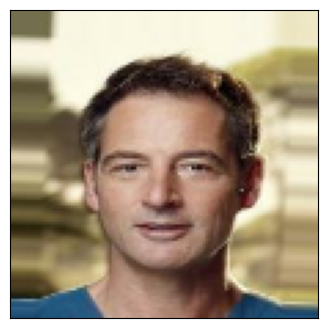

-----------------------
-----------------------
True Attributes: Arched_Eyebrows, Attractive, Blond_Hair, Bushy_Eyebrows, Heavy_Makeup, High_Cheekbones, No_Beard, Oval_Face, Rosy_Cheeks, Smiling, Wavy_Hair, Wearing_Lipstick, Young


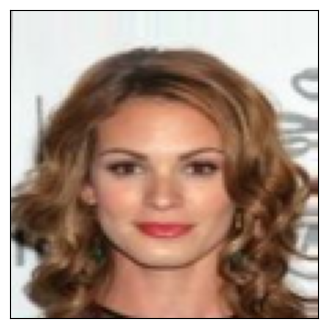

-----------------------
-----------------------
True Attributes: Attractive, Blond_Hair, No_Beard, Straight_Hair, Young


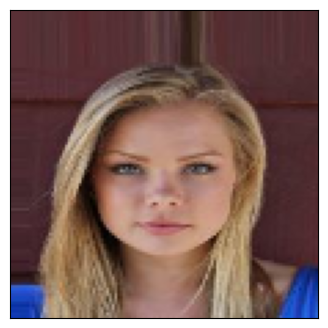

-----------------------
-----------------------
True Attributes: Black_Hair, Chubby, Goatee, Male, Mouth_Slightly_Open, Narrow_Eyes, Sideburns, Young


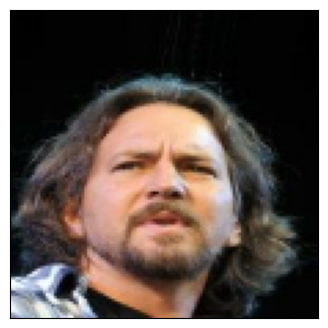

-----------------------
-----------------------
True Attributes: Bags_Under_Eyes, Bangs, Big_Lips, Big_Nose, Black_Hair, Bushy_Eyebrows, Male, Mouth_Slightly_Open, No_Beard, Smiling, Straight_Hair, Young


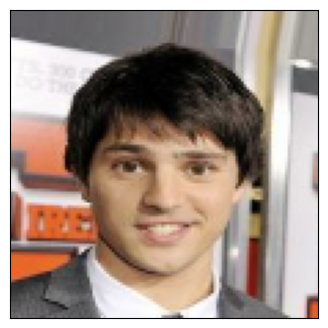

-----------------------


In [15]:
images, labels = next(iter(train_ds))
images, labels = images.numpy()[:5], labels.numpy()[:5]

plot_images(images, labels)

In [14]:
def vgg16_model():
    '''
    This function is used to create the model. In this model i'll be using vgg16 pretrained model on vggface dataset.
    Notice i'm using GlobalAveragePooling instead of Dense layer.
    
    Returns:
        classifier (tf.keras.Model) : Custom model with resnet_50 pretrained.
    '''
    vgg_features = VGG16(include_top=False, input_shape=(112, 112, 3), pooling='avg', weights=None)
    face_weights = tf.keras.utils.get_file('vgg16_notop_weights', FACE_WEIGHT_VGG16)
    vgg_features.load_weights(face_weights)
    for layer in vgg_features.layers:
        layer.trainable = False
    classifier = Sequential([
        vgg_features,
        Dense(len(attr2idx)),
        Activation('sigmoid')
    ])
    return classifier

def resnet50_model():
    '''
    This function is used to create the model. In this model i'll be using resnet50 pretrained model on imagenet dataset.
    Notice i'm using GlobalAveragePooling instead of Dense layer.
    
    Returns:
        classifier (tf.keras.Model) : Custom model with resnet_50 pretrained.
    '''
    resnet_features = ResNet50(include_top=False, input_shape=(112, 112, 3), pooling='avg')
    for layer in resnet_features.layers:
        layer.trainable = False
    classifier = Sequential([
        resnet_features,
        Dense(len(attr2idx)),
        Activation('sigmoid')
    ])
    return classifier

def initializer_model(optimizer, loss, metrics):
    '''
    This function declare and compile the model with given params.
    
    Params:
        optimizer (string) : Optimizer for model
        loss (string) : Loss to minimize
        metrics (list) : Metrics to visualize while training
        
    Returns:
        model (tf.keras.Model) : Compiled model
    '''
#     model = resnet50_model()
    model = vgg16_model()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def load_or_initialize_model(path, loss, optimizer='adam', metrics=['accuracy']):
    '''
    This function load checkpoint weights to the model if there is present any otherwise just initialize model.
    
    Params:
        path (string) : Path to the model checkpoint
        loss (string) : Loss to minimize
        optimizer (string, optional) : Optimizer for the model
        metrics (list, optional) : Metrics to visualize while training
        
    Returns:
        model (tf.keras.Model) : Loaded model if checkpoint present otherwise new instance of model.
    '''
    model = initializer_model(optimizer, loss, metrics)
    print('Initialized Model...')
    checkpoint_dir = os.path.dirname(path)
    if len(glob.glob('./*.h5')) > 0:
        model = keras.models.load_model(glob.glob('./*.h5')[0])
        print("Loaded pretrained Model: " + glob.glob('./*.h5')[0] + "...")
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
        print('Created checkpoint directory...')
    elif len(os.listdir(checkpoint_dir)) > 0:
        model.load_weights(path)
        print("Loading Weights...")
        
    return model

def generate_class_weights(attr_names):
    '''
    This function used attr_names and attr_df to generate class_weight for losses to deal with
    unbalanced data as you can see in above histograms. This should e noticed that function returning
    value_counts[-1] due to we are more concerned for minorities class and mapping that to weights.
    
    Params:
        attr_name (list) : list of columns of attr_df to generate class_weight
        
    Returns:
        weights (dict) : Generated weight dict mapping label index to weights.
    '''
    weights = dict()
    for i, attr_name in enumerate(attr_names):
        value_counts = dict(attr_df[attr_name].value_counts(normalize=True))
        weights[i] = value_counts[-1]
    total_sum = sum(list(weights.values()))
    weights = {k: v/total_sum for k, v in weights.items()}
    return weights

In [15]:
checkpoint_filepath = './checkpoint/cp.ckpt'

# Hyperparameters
optimizer = 'adam'
bc_loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
EPOCHS = 20

# Loading or Initializing model
model = load_or_initialize_model(checkpoint_filepath, bc_loss, optimizer, metrics)

Initialized Model...
Loaded pretrained Model: .\model_20_epoch.h5...
Loading Weights...


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 40)                81960     
                                                                 
 activation (Activation)     (None, 40)                0         
                                                                 
Total params: 23,669,672
Trainable params: 81,960
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
# callback definitions
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, verbose=1)
class_weights = generate_class_weights(attr_names)

# training
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping, model_checkpoint],
                   class_weight=class_weights)
model.save('./model_vggface_loss_{}.h5'.format(history.history['val_loss'][-1]))

Epoch 1/20
2865/2865 [==============================] - ETA: 0s - loss: 0.0079 - binary_accuracy: 0.8500
Epoch 1: saving model to ./checkpoint\cp.ckpt
2865/2865 [==============================] - 1726s 601ms/step - loss: 0.0079 - binary_accuracy: 0.8500 - val_loss: 0.3481 - val_binary_accuracy: 0.8479
Epoch 2/20
2864/2865 [============================>.] - ETA: 0s - loss: 0.0079 - binary_accuracy: 0.8500
Epoch 2: saving model to ./checkpoint\cp.ckpt
2865/2865 [==============================] - 139s 48ms/step - loss: 0.0079 - binary_accuracy: 0.8500 - val_loss: 0.3464 - val_binary_accuracy: 0.8483
Epoch 3/20
2864/2865 [============================>.] - ETA: 0s - loss: 0.0079 - binary_accuracy: 0.8501
Epoch 3: saving model to ./checkpoint\cp.ckpt
2865/2865 [==============================] - 139s 48ms/step - loss: 0.0079 - binary_accuracy: 0.8501 - val_loss: 0.3465 - val_binary_accuracy: 0.8484
Epoch 4/20
2864/2865 [============================>.] - ETA: 0s - loss: 0.0079 - binary_accurac

In [4]:
modelpath = 'model_vggface_v2.h5'

# Hyperparameters
optimizer = 'adam'
bc_loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
EPOCHS = 20

# Loading or Initializing model
model = keras.models.load_model(modelpath)

In [6]:
model.compile(optimizer=optimizer, loss=bc_loss, metrics=metrics)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 40)                81960     
                                                                 
 activation (Activation)     (None, 40)                0         
                                                                 
Total params: 23,669,672
Trainable params: 81,960
Non-trainable params: 23,587,712
_________________________________________________________________


2/2 [==============================] - 2s 11ms/step
-----------------------
True Attributes: Arched_Eyebrows, Attractive, Big_Lips, Blond_Hair, Heavy_Makeup, High_Cheekbones, Mouth_Slightly_Open, No_Beard, Rosy_Cheeks, Smiling, Wearing_Lipstick, Wearing_Necklace
Predicted Attributes: Arched_Eyebrows, Attractive, Bangs, Big_Lips, Blond_Hair, Heavy_Makeup, High_Cheekbones, Mouth_Slightly_Open, No_Beard, Pointy_Nose, Rosy_Cheeks, Smiling, Wavy_Hair, Wearing_Lipstick, Wearing_Necklace, Young


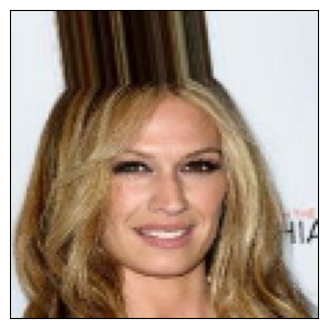

-----------------------
-----------------------
True Attributes: Male, No_Beard, Young
Predicted Attributes: Attractive, High_Cheekbones, Male, Mouth_Slightly_Open, No_Beard, Smiling, Wearing_Lipstick, Young


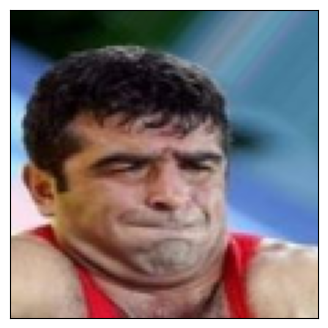

-----------------------
-----------------------
True Attributes: Black_Hair, High_Cheekbones, Male, No_Beard, Oval_Face, Pointy_Nose, Smiling, Wearing_Necktie
Predicted Attributes: High_Cheekbones, Male, No_Beard, Smiling, Wearing_Lipstick, Young


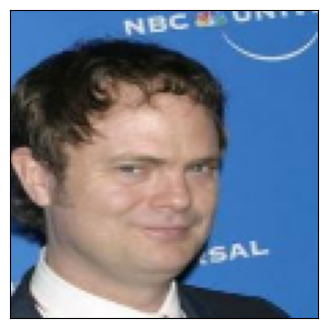

-----------------------
-----------------------
True Attributes: Black_Hair, Blurry, Eyeglasses, High_Cheekbones, Male, Mouth_Slightly_Open, No_Beard, Pointy_Nose, Smiling, Young
Predicted Attributes: 5_o_Clock_Shadow, Bags_Under_Eyes, Big_Nose, Black_Hair, Male, No_Beard, Straight_Hair, Wearing_Necktie, Young


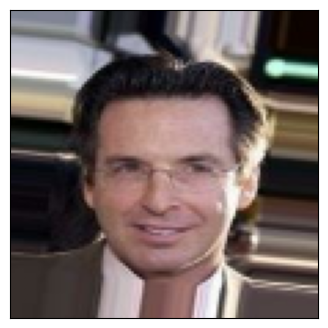

-----------------------
-----------------------
True Attributes: Attractive, Big_Lips, Heavy_Makeup, High_Cheekbones, Mouth_Slightly_Open, No_Beard, Rosy_Cheeks, Smiling, Wearing_Lipstick, Young
Predicted Attributes: Arched_Eyebrows, Attractive, Heavy_Makeup, High_Cheekbones, Mouth_Slightly_Open, No_Beard, Pointy_Nose, Smiling, Wavy_Hair, Wearing_Lipstick, Young


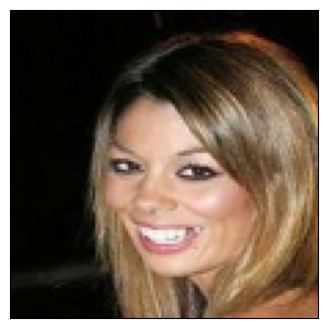

-----------------------


In [18]:
# Tuning Parameter
thershold = 0.4
#--------
batch = next(iter(test_ds))
test_images, test_labels = batch

# Predicting Labels
pred_labels = model.predict(test_images)

# Changing Predicted labels to One-Hot
pred_labels[pred_labels >= thershold] = 1
pred_labels[pred_labels < thershold] = 0

# Processing for plotting
test_images = test_images.numpy()[:5]
test_labels = test_labels.numpy()[:5]
pred_labels = pred_labels[:5]

# Finally Plotting
plot_images(test_images, test_labels, pred_labels)

In [25]:
print(os.sep)

\
